# Algotytmy obliczania otoczki wypukłej krok po kroku

In [98]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.visualizer.main import Visualizer
from functools import cmp_to_key

## Wczytywanie, zapisywanie zbiorów punktów do plikow

In [99]:
def save_points(f_path, points):
    with open(f_path, "w") as f:
        f.write(f'{points}')

def load_points(f_path):
    with open(f_path, "r") as f:
        return eval(f.readlines()[0])

## Funkcje wyznacznika, orientacji oraz odległości

In [100]:
def det(a, b, c):
    return ((b[0] - a[0]) * (c[1] - b[1]) - (b[1]-a[1]) * (c[0] - b[0]) )

def points_orientation(a, b, c, eps = 0):
    computed_det = det(a, b, c)
    if computed_det > eps: return 1 #counter-clockwise turn
    elif computed_det < -eps: return -1
    return 0

def points_distance_square(a, b):
    return ((a[0]-b[0])**2 + (a[1]-b[1])**2)

## Algorytmy znajdowania otoczki wypukłej

Wszyskie zaimplementowane poniżej algorytmy przyjmują listę punktów w postaci [(x1, y1)...] oraz zwracają listę kolejnych punktów otoczki postaci [(x1, y1)...]


### Algorytm Grahama

Algorytm Grahama tworzy otoczkę wypukłą poprzez utrzymywanie stosu, w którym znajdują się punkty, które mogą, ale nie muszą tworzyć otoczki wypukłej. Za każdym razem jest wstawiany na stos jeden punkt z zbioru punktów i jest on usuwany ze stosu, jeżeli nie jest punktem otoczki. Kiedy algorytm kończy się, stos zawiera tylko punkty otoczki wypukłej w kierunku przeciwnym do ruchu wskazówek zegera.

Złożoność czasowa O(nlogn)

In [101]:
def graham_algorithm(points):
    lowest_y_point = points[0]
    for i in range(len(points)): 
        if points[i][1] < lowest_y_point[1] or (points[i][1] == lowest_y_point[1] and points[i][0] < lowest_y_point[0]): lowest_y_point = points[i] 

    def side_comp(x, y):
        orientation = points_orientation(lowest_y_point, x, y)
        if orientation == 0: return points_distance_square(lowest_y_point, x) - points_distance_square(lowest_y_point, y)
        return -orientation

    points.sort(key=cmp_to_key(side_comp))

    new_points = [lowest_y_point]

    for i in range(1, len(points)):
        if i == len(points)-1 or points_orientation(lowest_y_point, points[i], points[i+1]) != 0: new_points.append(points[i])

    S = [new_points[0]]
    
    for i in range(1, len(new_points)):
        while len(S) > 1 and points_orientation(S[-2], S[-1], new_points[i]) != 1: S.pop()

        S.append(new_points[i])

    return S

### Algorytm Jarvisa

Algorytm Jarvisa oblicza otoczkę wypukłą dla zbioru punktów przez technikę zwaną owijaniem paczki (gift wraping). Algorytm Jarvisa buduje sekwencję, w której każdy kolejny punkt ma najmniejszy kąt w odniesieniu do poprzedniego. Jeśli punkty mają ten sam kąt, wybieramy dalszy.

Złożoność czasowa O(nh) (gdzie h to wielkość zbioru wynikowego)

In [102]:
def jarvis_algorithm(points):
    on_chain = points[0]
    for i in range(len(points)): 
        if points[i][1] < on_chain[1] or (points[i][1] == on_chain[1] and points[i][0] < on_chain[0]): on_chain = points[i] 

    S = []
    while not S or on_chain != S[0]:
        S.append(on_chain)
        next = points[0]
        for point in points: 
            if next == on_chain or points_orientation(on_chain, next, point) == -1 or (points_orientation(on_chain, next, point) == 0 and points_distance_square(on_chain, next)< points_distance_square(on_chain, point)):
                next = point
        on_chain = next

    return S

### Algorytm Dziel i Zwyciężaj

Algorytm ten polega na rekurencyjnym podziale zbioru na dwie części, po których przeprocesowaniu następuje ich łączenie. Podział wykonujemy wedle pionowej prostej przechodzącej przez element środkowy względem wspł. x. W tym celu na początu sortujemy cały zbiór punktów. W momencie gdy zbiór zawiera jedynie <= 5 punktów, Wykonujemy brutalny algorytm wyszukiwania otoczki.

Łączenie odbywa się poprzez wybranie dla lewej otoczki punktu najbardziej wysuniętego w prawo p i dla prawej otoczki punktu najbardziej wysuniętego w lewo q. Następnie tworzymy dwa odcinki pq. Jeden z nich będziemy przesuwać w górę, a drugi w dół aż do utworzenia dolnej i górnej stycznej.

Złożoność O(nlogn)

In [103]:
# Driver code
def divide_and_conquer(points):
    points = sorted(points)
    new_points = [points[0]]
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: new_points.append(points[i])
    
    new_points.append(points[-1])

    return divide_and_conquer_main_func(new_points)

# Main function
def divide_and_conquer_main_func(points):
    if len(points) <= 5: return jarvis_algorithm(points)

    left_part = divide_and_conquer_main_func(points[:len(points)//2 + 2])
    right_part = divide_and_conquer_main_func(points[len(points)//2 + 2:])

    return merge(left_part, right_part)

# Merge function
def merge(a, b):

    if len(a) == 0: return b
    elif len(b) == 0: return a

    max_right_ind = 0
    for i in range(len(a)): 
        if a[i][0] > a[max_right_ind][0]: max_right_ind = i 

    max_left_ind = 0
    for i in range(len(b)): 
        if b[i][0] < b[max_left_ind][0]: max_left_ind = i 

    top_a_ind = bottom_a_ind = max_right_ind
    top_b_ind = bottom_b_ind = max_left_ind

 
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == -1 or (points_orientation(b[top_b_ind], a[top_a_ind], a[(top_a_ind + 1)%len(a)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[top_b_ind], a[(top_a_ind + 1)%len(a)])): 
            top_a_ind = (top_a_ind + 1)%len(a)

        while len(b) > 1 and points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 1 or (points_orientation(a[top_a_ind], b[top_b_ind], b[(top_b_ind - 1 + len(b))%len(b)]) == 0 and points_distance_square(b[top_b_ind], a[top_a_ind]) < points_distance_square(b[(top_b_ind - 1 + len(b))%len(b)], a[top_a_ind])): 
            top_b_ind = (top_b_ind - 1 + len(b))%len(b)
            done = False
            
        if done: break
        
    while True:
        done = True
        while len(a) > 1 and points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 1 or (points_orientation(b[bottom_b_ind], a[bottom_a_ind], a[(bottom_a_ind - 1 + len(a))%len(a)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[bottom_b_ind], a[(bottom_a_ind - 1 + len(a))%len(a)])): 
            bottom_a_ind = (bottom_a_ind - 1 + len(a))%len(a)

        while len(b) > 1 and points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == -1 or (points_orientation(a[bottom_a_ind], b[bottom_b_ind], b[(bottom_b_ind + 1)%len(b)]) == 0 and points_distance_square(b[bottom_b_ind], a[bottom_a_ind]) < points_distance_square(b[(bottom_b_ind + 1)%len(b)], a[bottom_a_ind])): 
            bottom_b_ind = (bottom_b_ind + 1)%len(b)
            done = False

        if done: break

    new_points = []
    i = top_a_ind
    while i != bottom_a_ind: 
        new_points.append(a[i])
        i = (i + 1) % len(a)
    new_points.append(a[bottom_a_ind])

    i = bottom_b_ind
    while i != top_b_ind: 
        new_points.append(b[i])
        i = (i + 1) % len(b)
    new_points.append(b[top_b_ind])

    return new_points

### Algorytm Chana

Algorytm Chana jest optymalnym względem zbioru wynikowego algorytmem znajdowania otoczki wypukłej. Oznacza to tyle, że niejako łącząc algorytm Grahama i Jarvisa łączy podejście O(nlogn) zależne od ilości danych z podejściem O(nh) zależnym od mnogości zbioru wynikowego. Polega on na stworzeniu pomiejszych otoczek podzbiorów punktów, a następnie na ich połączeniu.

Złożoność obliczeniowa O(nlogh)

In [128]:
def chan_algorithm(points):

    def most_acute(hull, a):
        left_before = points_orientation(a, hull[(len(hull) - 1) % len(hull)], hull[0])
        left_after = points_orientation(a, hull[0], hull[1% len(hull)])
        if left_before == 0 and left_after == 0: return hull[0] if points_distance_square(a, hull[0]) > points_distance_square(a, hull[1 %len(hull)]) else hull[1 % len(hull)]
        for x in range(len(hull)):
            mid_before = points_orientation(a, hull[(x + len(hull) - 1) % len(hull)], hull[x])
            mid_after = points_orientation(a, hull[x], hull[(x + 1) % len(hull)])
            if mid_after == 1 and (mid_before == 0 or mid_before == -1): 
                return hull[x]
	

    min_y_ind = 0
    for i in range(len(points)):
        if points[i][1] < points[min_y_ind][1]: min_y_ind = i

    for t in range(len(points)):
        m = min(2 ** t, len(points))
        hulls = [graham_algorithm(points[i * m:i * m +m]) for i in range((len(points)+m-1)//m)] 

        if len(hulls) == 1:  
            return hulls[0] 

        ans_hull = [] 
        on_chain = points[min_y_ind]

        # pseudo jarvis
        for i in range(m):
            ans_hull.append(on_chain)
            next = most_acute(hulls[0], on_chain)
            for j in range(1, len(hulls)):
                candidate = most_acute(hulls[j], on_chain)
                if points_orientation(on_chain, next, candidate) == -1 or (points_orientation(on_chain, next, candidate) == 0 and points_distance_square(on_chain, next) < points_distance_square(on_chain, candidate)):
                    next = candidate
                    
            on_chain = next
            if on_chain == points[min_y_ind]: return ans_hull

    return []      

### Algorytm przyrostowy

Tu opis

In [105]:
class Node:
    def __init__(self, point):
        self.point = point
        self.prev = None
        self.next = None

class DoublyLinkedList:
    def __init__(self):
        self.head = None
        self.tail = None

    def append(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.tail:
            new_node.prev = self.tail
            self.tail.next = new_node
            self.tail = new_node
        else:
            new_node.next = other.next
            new_node.prev = other
            other.next.prev = new_node
            other.next = new_node

        return new_node

    def prepend(self, point, other = None):
        new_node = Node(point)
        if not self.head:
            self.head = new_node
            self.tail = new_node
        elif not other or other == self.head:
            new_node.next = self.head
            self.head.prev = new_node
            self.head = new_node
        else:
            new_node.next = other
            new_node.prev = other.prev
            other.prev.next = new_node
            other.prev = new_node
        
        return new_node
    
    def get_next(self, other):
        if other == self.tail: return self.head
        return other.next

    def get_prv(self, other):
        if other == self.head: return self.tail
        return other.prev

    def delete(self, other):
        if self.head == self.tail and self.head == other: 
            self.head = self.tail = None

        if other == self.head:
            self.head = self.head.next
            self.head.prev = None
        elif other == self.tail:
            self.tail = self.tail.prev
            self.tail.next = None
        else: 
            other.prev.next = other.next
            other.next.prev = other.prev
            other.next = other.prev = None

        if self.head == None or self.tail == None:
            self.head = self.tail = None

    def to_list(self):
        current = self.head
        ans = []
        while current:
            ans.append(current.point)
            current = current.next
        return ans
    
    def amend_the_hull(self, point, other):
        c1 = c2 = other
        to_be_deleted = []
        
        while points_orientation(point, c1.point, self.get_next(c1).point) == -1 or (points_orientation(point, c1.point, self.get_next(c1).point) == 0 and points_distance_square(point, c1.point) < points_distance_square(point, self.get_next(c1).point)):
            if c1 != other: to_be_deleted.append(c1)
            c1 = self.get_next(c1)

        while points_orientation(point, c2.point, self.get_prv(c2).point) == 1 or (points_orientation(point, c2.point, self.get_prv(c2).point) == 0 and points_distance_square(point, c2.point) < points_distance_square(point, self.get_prv(c2).point)):
            if c2 != other: to_be_deleted.append(c2)
            c2 = self.get_prv(c2)

        if c1 != other and c2 != other:
            to_be_deleted.append(other)
        
        for x in to_be_deleted: self.delete(x)
        return self.prepend(point, c1)

def incremental(points):
    if len(points) < 2: return points 

    points = sorted(points)

    new_points = [points[0]]
    for i in range(1, len(points) - 1):
        if points[i][0] != points[i-1][0] or points[i][0] != points[i+1][0]: new_points.append(points[i])
    
    new_points.append(points[-1])
    
    CH = DoublyLinkedList()
    CH.append(new_points[0])
    added_last = CH.append(new_points[1])

    for i in range(2, len(new_points)): 
        added_last = CH.amend_the_hull(new_points[i], added_last)

        
    return CH.to_list()   

### Algorytm QuickHull

Tu opis

In [106]:
#dystans punktu p od linii, ktora laczy punkty a i b

def distance(a,b,p):
    return abs((p[1]-a[1])*(b[0]-a[0]) - (b[1]-a[1])*(p[0]-a[0]))

def recur(a, b, p, ch, points):
    right = []
    if(len(p)==0):
        return
    #wyznaczam punkty po prawej stronie prostej ab
    for i in range(len(p)): 
        if(points_orientation(a, b, p[i]) == -1):
            right.append(p[i])

    #wyznaczam punkt najdalej lezacy od prostej ab
    if(len(right)==0):
        return 
    
    else:
        dist = -1
        for i in range(len(right)):
            if distance(a,b,right[i]) > dist:
                index = i
                dist = distance(a,b,right[i])

        a_ind = ch.index(a)
        new_p = right[index]
        ch.insert(a_ind+1, new_p)
        recur(a, new_p, right, ch, points)
        recur(new_p, b, right, ch, points)    
    
def Quickhull(points):
    if len(points) < 2: return points
    ch = [] 

    a = min(points)
    b = max(points)   

    ch.append(a)
    ch.append(b)
    
    recur(a,b,points,ch,points)
    recur(b,a,points,ch,points)
    
    return ch

### Algorytm Upper-Lower

Tu opis

In [ ]:
   
def UpperAndLower(points):
    if len(points) < 3: return points
    sorted_points = sorted(points, key=lambda x: (x[0], x[1]))

    upper, lower = [sorted_points[0], sorted_points[1]], [sorted_points[0], sorted_points[1]]

    for idx in range(2, len(sorted_points)):
        while len(upper) > 1 and points_orientation(upper[-2], upper[-1], sorted_points[idx]) != -1:
            upper.pop()
        upper.append(sorted_points[idx])     

        while len(lower) > 1 and points_orientation(lower[-2], lower[-1], sorted_points[idx]) != 1:
            lower.pop()
        lower.append(sorted_points[idx])
    lower.reverse()
    
    upper.pop()
    lower.pop()
    
    hull = lower + upper
    
    return list(reversed(hull))

: 

[(0, 0), (2, 0), (2, 2), (0, 2)]
[(0, 0), (2, 0), (2, 2), (0, 2)]
[(0, 0), (2, 0), (2, 2), (0, 2)]
[(0, 2), (0, 0), (2, 0), (2, 2)]
[(0, 0), (2, 0), (2, 2), (0, 2)]
[(0, 0), (2, 0), (2, 2), (0, 2)]
[(0, 2), (0, 0), (2, 0), (2, 2)]


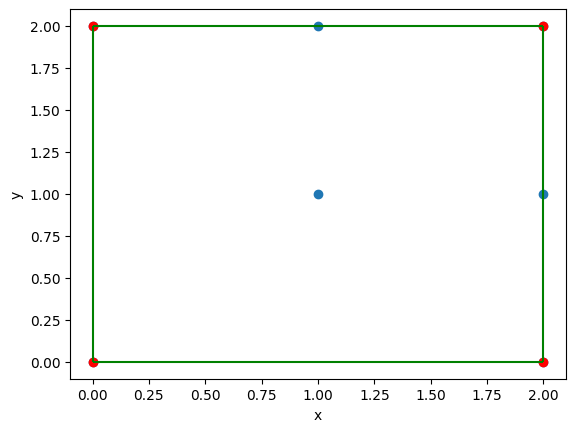

In [281]:
#TMP SYF

# points = [(0, 0), (0, 1.7973882603514757), (0, 2.0752403541505116), (0, 2.2185340801627396), (0, 2.6608040616600004), (0, 3.9393132458181257), (0, 4.500955174019103), (0, 6.10381997122909), (0, 7.613834400777135), (0, 8.50580304623626), (0, 9.490032788769971), (0, 10), (0.19966653659046707, 9.800333463409533), (1.1438086484599874, 8.856191351540012), (1.3082355490525677, 0), (1.5427484638692945, 1.5427484638692945), (1.5885826456879937, 0), (2.1837136463347817, 7.816286353665218), (2.196383939445521, 2.196383939445521), (2.5591114308476373, 0), (2.643793302924764, 2.643793302924764), (2.6980706555319376, 2.6980706555319376), (2.7871011015218237, 0), (2.8103133828068483, 7.189686617193152), (2.944724966178429, 7.055275033821571), (3.9525641380748233, 0), (4.07851557705991, 5.92148442294009), (4.142520093348764, 4.142520093348764), (4.7312824099383635, 0), (5.099125014270967, 0), (6.330742379366302, 3.669257620633698), (6.38058017203766, 3.61941982796234), (6.584595708497838, 6.584595708497838), (6.606480696570816, 6.606480696570816), (6.71771023223844, 3.2822897677615597), (7.246855577824873, 0), (7.718160744943332, 7.718160744943332), (7.884652129621108, 7.884652129621108), (7.964150626275728, 0), (8.031189732051807, 0), (8.41506433861673, 8.41506433861673), (9.862473974771763, 0.13752602522823665), (10, 0), (10, 10)]
points = [(0, 0), (2, 0), (0, 2), (2, 2), (1, 1), (2, 1), (1, 2)]
# print(len(graham_algorithm(points)), (jarvis_algorithm(points)), (chan_algorithm(points)))

vis = Visualizer()
vis.add_point(points)

print(graham_algorithm(points))
print(jarvis_algorithm(points))
print(chan_algorithm(points))
print(divide_and_conquer(points))
print(incremental(points))
print(Quickhull(points))
print(UpperAndLower(points))


ans = chan_algorithm(points)
for i in range(1, len(ans)): vis.add_line_segment((ans[i-1], ans[i]), color = 'green')
vis.add_line_segment((ans[0], ans[-1]), color = 'green')
vis.add_point(ans, color='red')
vis.show()